<a href="https://colab.research.google.com/github/aaguil8a/sales_predictions/blob/main/sales_predictionsipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
% pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
import pandas_profiling as pdpf


In [2]:
filename = 'https://raw.githubusercontent.com/aaguil8a/DS/main/sales_predictions%20(1).csv'

df = pd.read_csv(filename, index_col=0, parse_dates=True)

df.head(30)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
Item_Identifier,,,,,,,,,,,
FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
FDP36,10.395,Regular,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
FDO10,13.650,Regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528
FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,NaN,Tier 2,Supermarket Type1,1076.5986


In [3]:
# Removes white spaces from dataframe

def remove_whitespace(x):
    try:
        # remove spaces inside and outside of string
        x = "_".join(x.split())

    except:
        pass
    return x


df = df.applymap(remove_whitespace)


# Data Cleaning 


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8523 entries, FDA15 to DRG01
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                7060 non-null   float64
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Identifier          8523 non-null   object 
 6   Outlet_Establishment_Year  8523 non-null   int64  
 7   Outlet_Size                6113 non-null   object 
 8   Outlet_Location_Type       8523 non-null   object 
 9   Outlet_Type                8523 non-null   object 
 10  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 799.0+ KB


In [5]:
df.shape # 8524 rows and 12 columns

(8523, 11)

In [6]:
# Count duplicate on a column 
print(df.duplicated().sum())

# # non-duplicates
print((~df.duplicated()).sum())




0
8523


In [7]:
# missing data
# Gives you missing percent of data
((df
  .isna()
  .mean()
  * 100)
  .pipe(lambda ser : ser[ser > 0])
)



Item_Weight    17.165317
Outlet_Size    28.276428
dtype: float64

In [8]:
# Checks for more missing values that may not have been picked up

missing_values = ['NaN','na','--','n/a']

df = pd.read_csv(filename,na_values=missing_values)


In [9]:
# sum of missing values

df.isnull().sum()




Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [10]:
# total number of missing values

df.isnull().sum().sum()

3873

In [11]:
# I use median given that some rows skew to high or low extremes

# Replace using median 
df['Outlet_Size'].fillna('Medium', inplace=True)
median = df.fillna(df.median(), inplace=True)




In [12]:
df.isnull().sum() # No missing values



Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [13]:
# Looking for inconsistent categories of data
df.value_counts()

Item_Identifier  Item_Weight  Item_Fat_Content  Item_Visibility  Item_Type              Item_MRP  Outlet_Identifier  Outlet_Establishment_Year  Outlet_Size  Outlet_Location_Type  Outlet_Type        Item_Outlet_Sales
NCZ54            14.650       Low Fat           0.083699         Household              163.4552  OUT018             2009                       Medium       Tier 3                Supermarket Type2  2599.2832            1
FDJ27            17.700       Regular           0.122565         Meat                   103.8674  OUT017             2007                       Medium       Tier 2                Supermarket Type1  1528.0110            1
FDJ22            12.600       Low Fat           0.092464         Snack Foods            190.9504  OUT019             1985                       Small        Tier 1                Grocery Store      383.5008             1
                 18.750       Low Fat           0.052800         Snack Foods            193.2504  OUT035             2004

In [14]:
# replace the inconsistent categories
# Assumed that LS means low fat
replacement = {'Low Fat': 'Low_Fat',
                'LF': 'Low_Fat',
               'reg': 'Regular',
               'Low_Fat': 'Low_Fat',
               'low fat': 'Low_Fat'
    

}

df['Item_Fat_Content'].replace(replacement,inplace=True)




In [15]:
# Checked if it worked
df.Item_Fat_Content.value_counts()

Low_Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

# Data Visualization

In [18]:
# Statistics for numerical columns

x = df[['Item_Weight','Item_Visibility','Item_MRP','Outlet_Establishment_Year','Item_Outlet_Sales']]

x.describe().loc[['min','max','mean']]

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
min,4.55500,0.000000,31.290000,1985.000000,33.290000
max,21.35000,0.328391,266.888400,2009.000000,13086.964800
mean,12.81342,0.066132,140.992782,1997.831867,2181.288914


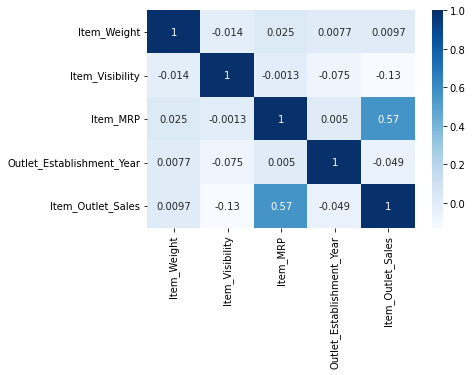

In [19]:
# We see that there correlation between: Item_MRP & Item_Outlet_Sales
corr = df.corr();
sns.heatmap(corr,cmap='Blues', annot=True);

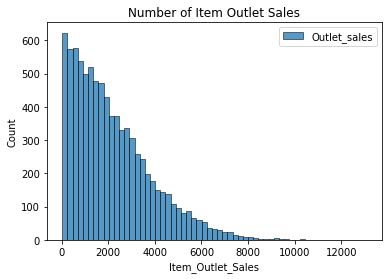

In [20]:
# lets explore 
sns.histplot(df['Item_Outlet_Sales'], label = 'Outlet_sales')
plt.title('Number of Item Outlet Sales')
plt.legend();

# we see a tail distribution

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


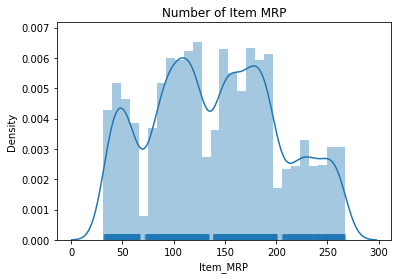

In [21]:
# There are several peaks with our Item_MRP
plt.title('Number of Item MRP');
sns.distplot(df.Item_MRP, rug=True, rug_kws={'alpha':.2});

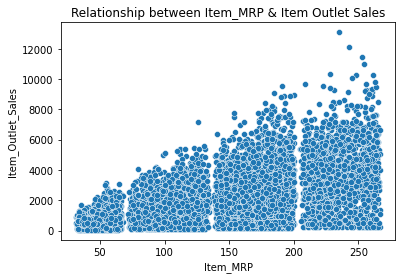

In [22]:
# looking at relationship: left skew
sns.scatterplot(y='Item_Outlet_Sales', x='Item_MRP', data=df);
plt.title('Relationship between Item_MRP & Item Outlet Sales');

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


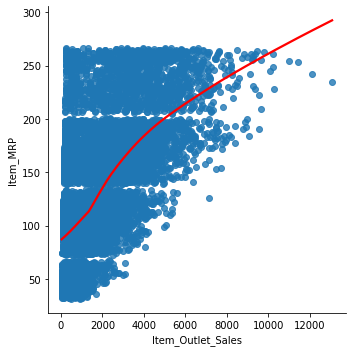

In [23]:
# If we change item_mpr count we not total a non-linear relationship
sns.lmplot('Item_Outlet_Sales', 'Item_MRP', data=df, lowess=True, line_kws={'color':'red'});

No handles with labels found to put in legend.


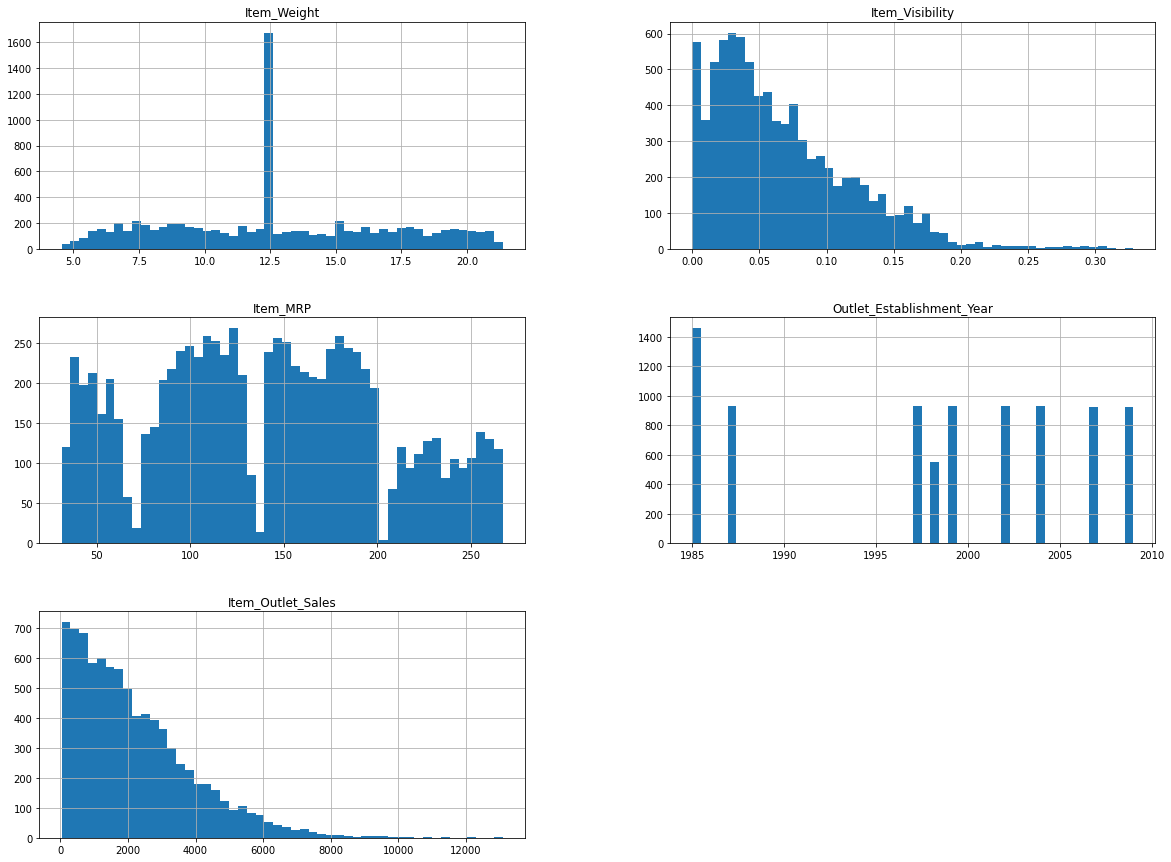

In [24]:
# looking at other numeric figs
df.hist(bins=50,figsize=(20,15))
plt.legend()

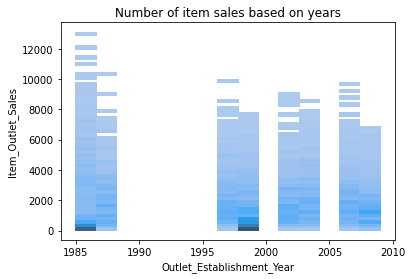

In [25]:
# looking at year and item_sales
sns.histplot(y='Item_Outlet_Sales', x='Outlet_Establishment_Year', data=df);
plt.title('Number of item sales based on years');


In [26]:
# changing year into datetime 
df['Outlet_Establishment_Year'] = pd.to_datetime(df['Outlet_Establishment_Year'], format='%Y')

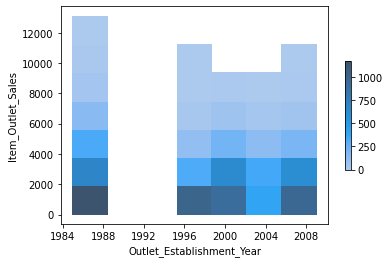

In [27]:
# see that most sales happend before internet; but we see in 2008 there is same peak as 1996.
sns.histplot(df, x ='Outlet_Establishment_Year', y='Item_Outlet_Sales',
              bins=7,
    cbar=True, cbar_kws=dict(shrink=.5),
);

# Feature Engineering

In [28]:
# # summary of variables
# pdpf.ProfileReport(df)

In [29]:
# let's inspect the cardinality, this is the number
# of different labels, for the different categorical variables

print('Number of categories in the variable Item Identifier: {}'.format(
    len(df.Item_Identifier.unique())))

print('Number of categories in the variable Item Fat Content: {}'.format(
    len(df.Item_Fat_Content.unique())))

print('Number of categories in the variable Item Type: {}'.format(
    len(df.Item_Type.unique())))

print('Number of categories in the variable Outlet Identifier: {}'.format(
    len(df.Outlet_Identifier.unique())))

print('Number of categories in the variable Outlet Size: {}'.format(
    len(df.Outlet_Size.unique())))


print('Number of categories in the variable Outlet Location Type: {}'.format(
    len(df.Outlet_Location_Type.unique())))

print('Number of categories in the variable Outlet Type: {}'.format(
    len(df.Outlet_Type.unique())))

print('Total number of item outlet sales: {}'.format(len(df)))

Number of categories in the variable Item Identifier: 1559
Number of categories in the variable Item Fat Content: 2
Number of categories in the variable Item Type: 16
Number of categories in the variable Outlet Identifier: 10
Number of categories in the variable Outlet Size: 3
Number of categories in the variable Outlet Location Type: 3
Number of categories in the variable Outlet Type: 4
Total number of item outlet sales: 8523


In [30]:
# remove item identifier no info
del df['Item_Identifier']

In [31]:
# making item fat content into numeric
df['Item_Fat_Content'] = df.Item_Fat_Content.replace({'Low_Fat':1, 'Regular':0})

In [32]:
# checking
df.Item_Fat_Content.value_counts()


1    5517
0    3006
Name: Item_Fat_Content, dtype: int64

In [45]:
cat = ['Item_Type','Outlet_Identifier','Outlet_Size','Outlet_Location_Type','Outlet_Type']

In [46]:
df = pd.get_dummies(df, columns = cat, drop_first = True)

In [53]:
# Removing Item_Outlet Sales and storing it in variable y
y = df.Item_Outlet_Sales
X = df.drop(columns=['Item_Outlet_Sales','Outlet_Establishment_Year'])

In [54]:
X = sm.add_constant(X)
X.head()

,const,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,1.0,9.30,1,0.016047,249.8092,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0
1,1.0,5.92,0,0.019278,48.2692,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0
2,1.0,17.50,1,0.016760,141.6180,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0
3,1.0,19.20,0,0.000000,182.0950,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,1.0,8.93,1,0.000000,53.8614,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


# Linear Model

In [55]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     392.0
Date:                Mon, 11 Oct 2021   Prob (F-statistic):               0.00
Time:                        02:59:55   Log-Likelihood:                -71988.
No. Observations:                8523   AIC:                         1.440e+05
Df Residuals:                    8494   BIC:                         1.442e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [56]:

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [57]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [58]:
# Instantiate and fit the model.
reg_model= LinearRegression()
reg_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [59]:
# Our model RMSE is high so it failing to account for important features
print('Training RMSE:', np.sqrt(mean_squared_error(y_train, reg_model.predict(X_train))))
print('Testing RMSE:', np.sqrt(mean_squared_error(y_test, reg_model.predict(X_test))))

Training RMSE: 1139.1040937388918
Testing RMSE: 1092.8630817241494


In [60]:
# Our features explain 55 percent of the variance for Item_Outlet_Sales
train_score = reg_model.score(X_train, y_train)
print(train_score)

0.5615551419174628


In [61]:
test_score = reg_model.score(X_test, y_test)
print(test_score)

0.5671041872384912


# Decision Tree Model

In [66]:
from sklearn.tree import DecisionTreeRegressor

In [67]:
y = df.Item_Outlet_Sales
X = df.drop(columns=['Item_Outlet_Sales','Outlet_Establishment_Year'])

In [68]:
X.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,9.30,1,0.016047,249.8092,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0
1,5.92,0,0.019278,48.2692,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0
2,17.50,1,0.016760,141.6180,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0
3,19.20,0,0.000000,182.0950,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,8.93,1,0.000000,53.8614,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [70]:
dec_tree = DecisionTreeRegressor(random_state = 42)

In [72]:
# fit model

dec_tree.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [73]:
# default tree.

train_preds = dec_tree.predict(X_train)
test_preds = dec_tree.predict(X_test)

In [74]:
# we can see that it is overfitting

train_score = dec_tree.score(X_train,y_train)
test_score = dec_tree.score(X_test, y_test)
print(train_score)
print(test_score)

1.0
0.2051006802200408


In [75]:
# 2) Determine the depth of the default tree.
# it is 36
dec_tree.get_depth()

38

In [77]:
# 3) Optimize the max_depth based on the R2 score.

# List of values to try for max_depth:
max_depth_range = list(range(2, 36)) # will try every value between 2 and 36
# List to store the score for each value of max_depth:
r2 = []
for depth in max_depth_range:
    dec_tree = DecisionTreeRegressor(max_depth = depth, 
                             random_state = 42)
    dec_tree.fit(X_train, y_train)
    score = dec_tree.score(X_test, y_test)
    r2.append(score)

print(r2)

[0.3465043845499205, 0.470942119899096, 0.574596803745578, 0.5856983281382546, 0.5790563600387593, 0.5668013591349559, 0.5556484080952053, 0.5243215306033036, 0.5137495144725761, 0.488887229266858, 0.4371656746378553, 0.41800633683027544, 0.39432628372396544, 0.3576904119416785, 0.3260896223903149, 0.284884303153217, 0.27067567632012246, 0.2713085174892007, 0.21743354578713103, 0.21564375091417076, 0.2155978730429159, 0.18845491554350058, 0.20252572577642103, 0.19376191588225544, 0.17653097491990943, 0.17732577716922648, 0.17248352934162425, 0.16455828363151903, 0.18719388371732815, 0.17265242597018904, 0.1727423278457596, 0.1734520341932897, 0.1714500777407476, 0.15708349091346874]


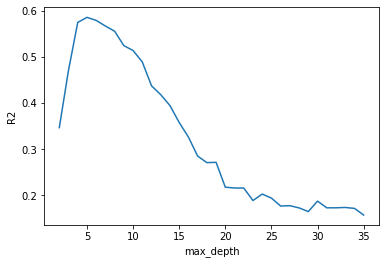

In [78]:
# Visualize which max_depth leads to the highest r2 score
import matplotlib.pyplot as plt
plt.plot(max_depth_range, r2)
plt.xlabel('max_depth')
plt.ylabel('R2');


In [80]:
# What is the r2 of your final model on the training set and on the test set?

# Let's run the model with our optimized value for max_depth, which is 7
dec_tree_9 = DecisionTreeRegressor(max_depth = 5, random_state = 42)
dec_tree_9.fit(X_train, y_train)
train_9_score = dec_tree_9.score(X_train, y_train)
test_9_score = dec_tree_9.score(X_test, y_test)
print(train_9_score)
print(test_9_score)

0.612057803720431
0.5856983281382546


In [94]:
print('Training RMSE:', np.sqrt(mean_squared_error(y_train, dec_tree.predict(X_train))))
print('Testing RMSE:', np.sqrt(mean_squared_error(y_test, dec_tree.predict(X_test))))

Training RMSE: 757.6078724703484
Testing RMSE: 777.1870006803273


# Bagged Tree Model

In [84]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

In [85]:
# Bagged trees regressor
bt = BaggingRegressor()
bt.fit(X_train, y_train)

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=10,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [86]:
# training R2
bt.score(X_train, y_train)

0.916393553958389

In [87]:
# testing R2
bt.score(X_test, y_test)

0.5241895943797774

In [95]:
print('Training RMSE:', np.sqrt(mean_squared_error(y_train, bt.predict(X_train))))
print('Testing RMSE:', np.sqrt(mean_squared_error(y_test, bt.predict(X_test))))

Training RMSE: 493.74900897772204
Testing RMSE: 1174.5548333619852


 # Random Forest Model
   

In [88]:
# Random Forest regressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [90]:
# training R2
rf.score(X_train, y_train)

0.9366328179755801

In [91]:
# testing R2
rf.score(X_test, y_test)

0.5726995234823957

In [96]:
print('Training RMSE:', np.sqrt(mean_squared_error(y_train, rf.predict(X_train))))
print('Testing RMSE:', np.sqrt(mean_squared_error(y_test, rf.predict(X_test))))

Training RMSE: 429.8516050155273
Testing RMSE: 1113.0713829019826


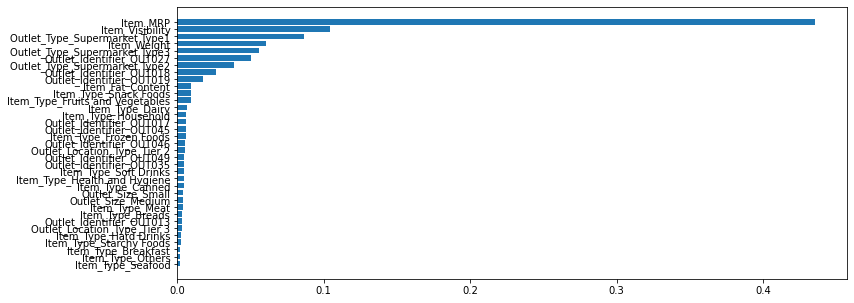

In [92]:
# Get random forest feature importances & plot 

rf_features = pd.DataFrame({'feature': X_train.columns, 'feature_importance': rf.feature_importances_})
rf_features.sort_values(by = 'feature_importance', inplace = True)

plt.figure(figsize = (12, 5))
plt.barh(rf_features['feature'], rf_features['feature_importance']);

# Comparing Model performance based on r^2.

For LM: our score is 56.
For Decision Tree: our score is 58.
For Bagged Tree: our score is 52.
For Random Forest: our score is 57.

# Comparing Models Based on RMSE

All of the models scored very high meaning that our models are not predicting well. 


# Recommendtions

I would recommend random forest did best out of all models.
